In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

PATH = "."
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df = pd.read_csv("/content/drive/MyDrive/Final Project/Final_Dataset/Second clean in Spark/clean_long_dataset.csv")
df = df[df["name"].str.contains("[0-9]{4}",regex=True)==True]

,date,category,name,open,high,low,close,volume,year,month,day,dayofyear,weekofyear,dayofweek,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,leadsine,ht_trendmode,add,div,max23,maxindex,min25,minindex,min27,max28,minidx,maxidx,mult,sub,sum,atan,ceil,cos,cosh,exp,floor,ln,log10,sin,sinh,sqrt,tan,tanh,adx,adxr,apo,aroondown,aroonup,aroonosc,bop,cci,cmo,dx,macd59,macdsignal60,macdhist61,macd62,macdsignal63,macdhist64,macd65,macdsignal66,macdhist67,mfi,minus_di,minus_dm,mom,plus_di,plus_dm,ppo,roc,rocp,rocr,rocr100,rsi,slowk,slowd,fastk82,fastd83,fastk84,fastd85,trix,ultosc,willr,upperband,middleband,lowerband,dema,ema,ht_trendline,kama,ma,mama,fama,midpoint,midprice,sar,sarext,sma,t3,tema,trima,wma,cdl2crows,cdl3blackcrows,cdl3inside,cdl3linestrike,cdl3outside,cdl3starsinsouth,cdl3whitesoldiers,cdlabandonedbaby,cdladvanceblock,cdlbelthold,cdlbreakaway,cdlclosingmarubozu,cdlconcealbabyswall,cdlcounterattack,cdldarkcloudcover,cdldoji,cdldojistar,cdldragonflydoji,cdlengulfing,cdleveningdojistar,cdleveningstar,cdlgapsidesidewhite,cdlgravestonedoji,cdlhammer,cdlhangingman,cdlharami,cdlharamicross,cdlhighwave,cdlhikkake,cdlhikkakemod,cdlhomingpigeon,cdlidentical3crows,cdlinneck,cdlinvertedhammer,cdlkicking,cdlkickingbylength,cdlladderbottom,cdllongleggeddoji,cdllongline,cdlmarubozu,cdlmatchinglow,cdlmathold,cdlmorningdojistar,cdlmorningstar,cdlonneck,cdlpiercing,cdlrickshawman,cdlrisefall3methods,cdlseparatinglines,cdlshootingstar,cdlshortline,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,avgprice,medprice,typprice,wclprice,beta,correl,linearreg,linearreg_angle,linearreg_intercept,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv,bias,ama,psy,dpo,vhf,rvi,BCI,BCTI,BDI,BDTI,BPI,BSI,NTD/USD
0,2011-05-19,Plastic,1301.TW,72.125885,72.750353,71.501417,72.125885,6510400.0,2011.0,5.0,19.0,139.0,20.0,3.0,23.992731,232.782864,2.029821,-1.760668,-0.796349,-0.990788,1.0,144.251770,1.017467,73.062576,75.0,64.944511,62.0,64.944511,73.062576,62.0,75.0,5201.753329,1.248935,2080.410141,1.556933,73.0,-0.991465,1.054008e+31,2.108016e+31,72.0,4.278413,1.858091,0.130374,1.054008e+31,8.492696,-0.131496,1.0,18.542748,18.874781,1.274952,42.857143,14.285714,-28.571429,0.000000,72.672884,19.569378,22.128897,1.465459,1.631872,-0.166413,1.274952,2.192526,-0.917573,1.400015,1.558421,-0.158405,52.865914,16.215675,4.157599,1.873413,25.431803,6.520557,1.822917,2.666686,0.026667,1.026667,102.666686,59.784689,74.999897,58.719077,74.999999,74.999897,78.760264,74.504483,0.315353,60.472218,-17.646905,73.113752,71.563861,70.013970,72.463854,69.411388,70.007898,69.806923,69.347005,71.720193,70.322620,71.345299,70.408591,67.952437,67.952437,69.347005,71.676740,72.623387,69.836169,70.634547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.125885,72.125885,72.125885,72.125885,0.074218,0.959444,71.590625,1.375881,71.278387,0.024018,0.774945,71.614643,0.600540,1.831666,2.539541,1.248935,2.102069e+08,8.229290e+06,159411200.0,0.013380,5.606583,50.000000,0.879936,0.288889,0.247496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-05-20,Plastic,1301.TW,72.750339,72.750339,71.189173,71.501404,4319120.0,2011.0,5.0,20.0,140.0,20.0,4.0,23.607954,240.266807,0.613696,-3.574650,-0.868344,-0.964710,1.0,143.939511,1.021930,73.062576,75.0,64.944511,62.0,64.944511,73.062576,62.0,75.0,5179.036427,1.561166,2085.718094,1.556811,72.0,-0.728116,5.644625e+30,1.128925e+31,71.0,4.269717,1.854315,0.685454,5.644625e+30,8.455850,-0.941408,1.0,18.532579,19.588224,1.122838,35.714286,7.142857,-28.571429,-0.800001,49.540516,13.727990,18.400374,1.372215,1.579941,-0.207726,1.122838,2.004385,-0.881547,1.311601,1.509057,-0.197456,41.427586,16.448601,4.172872,1.873383,23.866782,6.054803,1.600752,2.690558,0.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def data_shift_split(stock):
    stock['close_shift_10'] = stock['close'].shift(-10)

    # 刪除有nan的row
    stock.dropna(axis=0,inplace=True)
    
    # 取2002.TW 的技術指標 預測 收盤價
    X = stock.loc[:,'year':'rvi'].values
    y = stock.iloc[:, -1].values
    X_train, X_test, y_train, y_test =  train_test_split(X, y,
                     test_size=0.2,random_state = 1)
  
    return X_train, X_test, y_train, y_test

In [ ]:
def XGB_params_default(X_train, X_test, y_train, y_test ):
    scaler = preprocessing.StandardScaler()
  
    X_train = scaler.fit_transform(X_train)

    xgbr = xgb.XGBRegressor(seed = 20,objective='reg:squarederror')
    xgbr.fit(X_train, y_train)

    X_test = scaler.fit_transform(X_test)
    y_pred = xgbr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1-r2_score(y_test, y_pred))*(len(y_pred)-1)/(len(y_pred)-y_test.shape[0]-1)
    df_result_default = pd.DataFrame({"mse":mse, "rmse": rmse, "r2":r2, "adjusted_r2":adjusted_r2},index=[0])
    return df_result_default


In [ ]:

def XGB_params_select(X,y):

    
    params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
    xgbr = xgb.XGBRegressor(seed = 20 ,objective='reg:squarederror')
    clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
    clf.fit(X, y)
    
    
    print("Best parameters:", clf.best_params_)
    #print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
    best = clf.best_estimator_
    return best

In [ ]:
def XGB_params_best(X_train, X_test, y_train, y_test):
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)


    best.fit(X_train, y_train)

    X_test = scaler.fit_transform(X_test)
    y_pred_best = best.predict(X_test)
 



    # 列出R2 與 MSE值

    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
    r2_best = r2_score(y_test, y_pred_best)
    adjusted_r2_best = 1 - (1-r2_score(y_test, y_pred_best))*(len(y_pred_best)-1)/(len(y_pred_best)-y_test.shape[0]-1)
    
    df_mseR2 = pd.DataFrame({'mse':mse_best,'rmse':rmse_best,'r2':r2_best,'adjusted_r2':adjusted_r2_best},index=[0])
    return df_mseR2
    #print('mse: {}'.format(mse_best))
    #print('rmse: {}'.format(rmse_best))
    #print('r2: {}'.format(r2_best))
    #print('adjusted_r2: {}', format(adjusted_r2_best))

In [ ]:
def features_ranking_table(X_column_name,best):
    importance=pd.DataFrame(zip(X_column_name,best.feature_importances_), columns=['feature_name','importance'])
    importance= importance.sort_values("importance", ascending=False)
    return importance
    

In [ ]:
def features_ranking_bar(importance):
    %matplotlib inline
    plt.figure(figsize=(30, 40))

    sns.barplot(x="importance", y="feature_name", data=importance)
    plt.savefig(f'/content/drive/MyDrive/Final Project/XGboost/bar 圖/{stocks_name[i]}_bar圖.png')

In [1]:
stocks_name = list(df['name'].unique())

NameError: ignored

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 13.4min finished


Best parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.8999999999999999}
20
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  7.7min finished


Best parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.8999999999999999}
21
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 11.5min finished


Best parameters: {'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 20, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.8999999999999999}
22
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  8.2min finished


Best parameters: {'subsample': 0.7999999999999999, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7999999999999999}
23
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 13.3min finished


Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.8999999999999999}
24
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 10.8min finished


Best parameters: {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.5}
25
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 10.9min finished


Best parameters: {'subsample': 0.7999999999999999, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.2, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.8999999999999999}
26
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 10.7min finished


Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7999999999999999}
27
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 11.9min finished


Best parameters: {'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.8999999999999999}
28
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.3min finished


Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.8999999999999999}
29


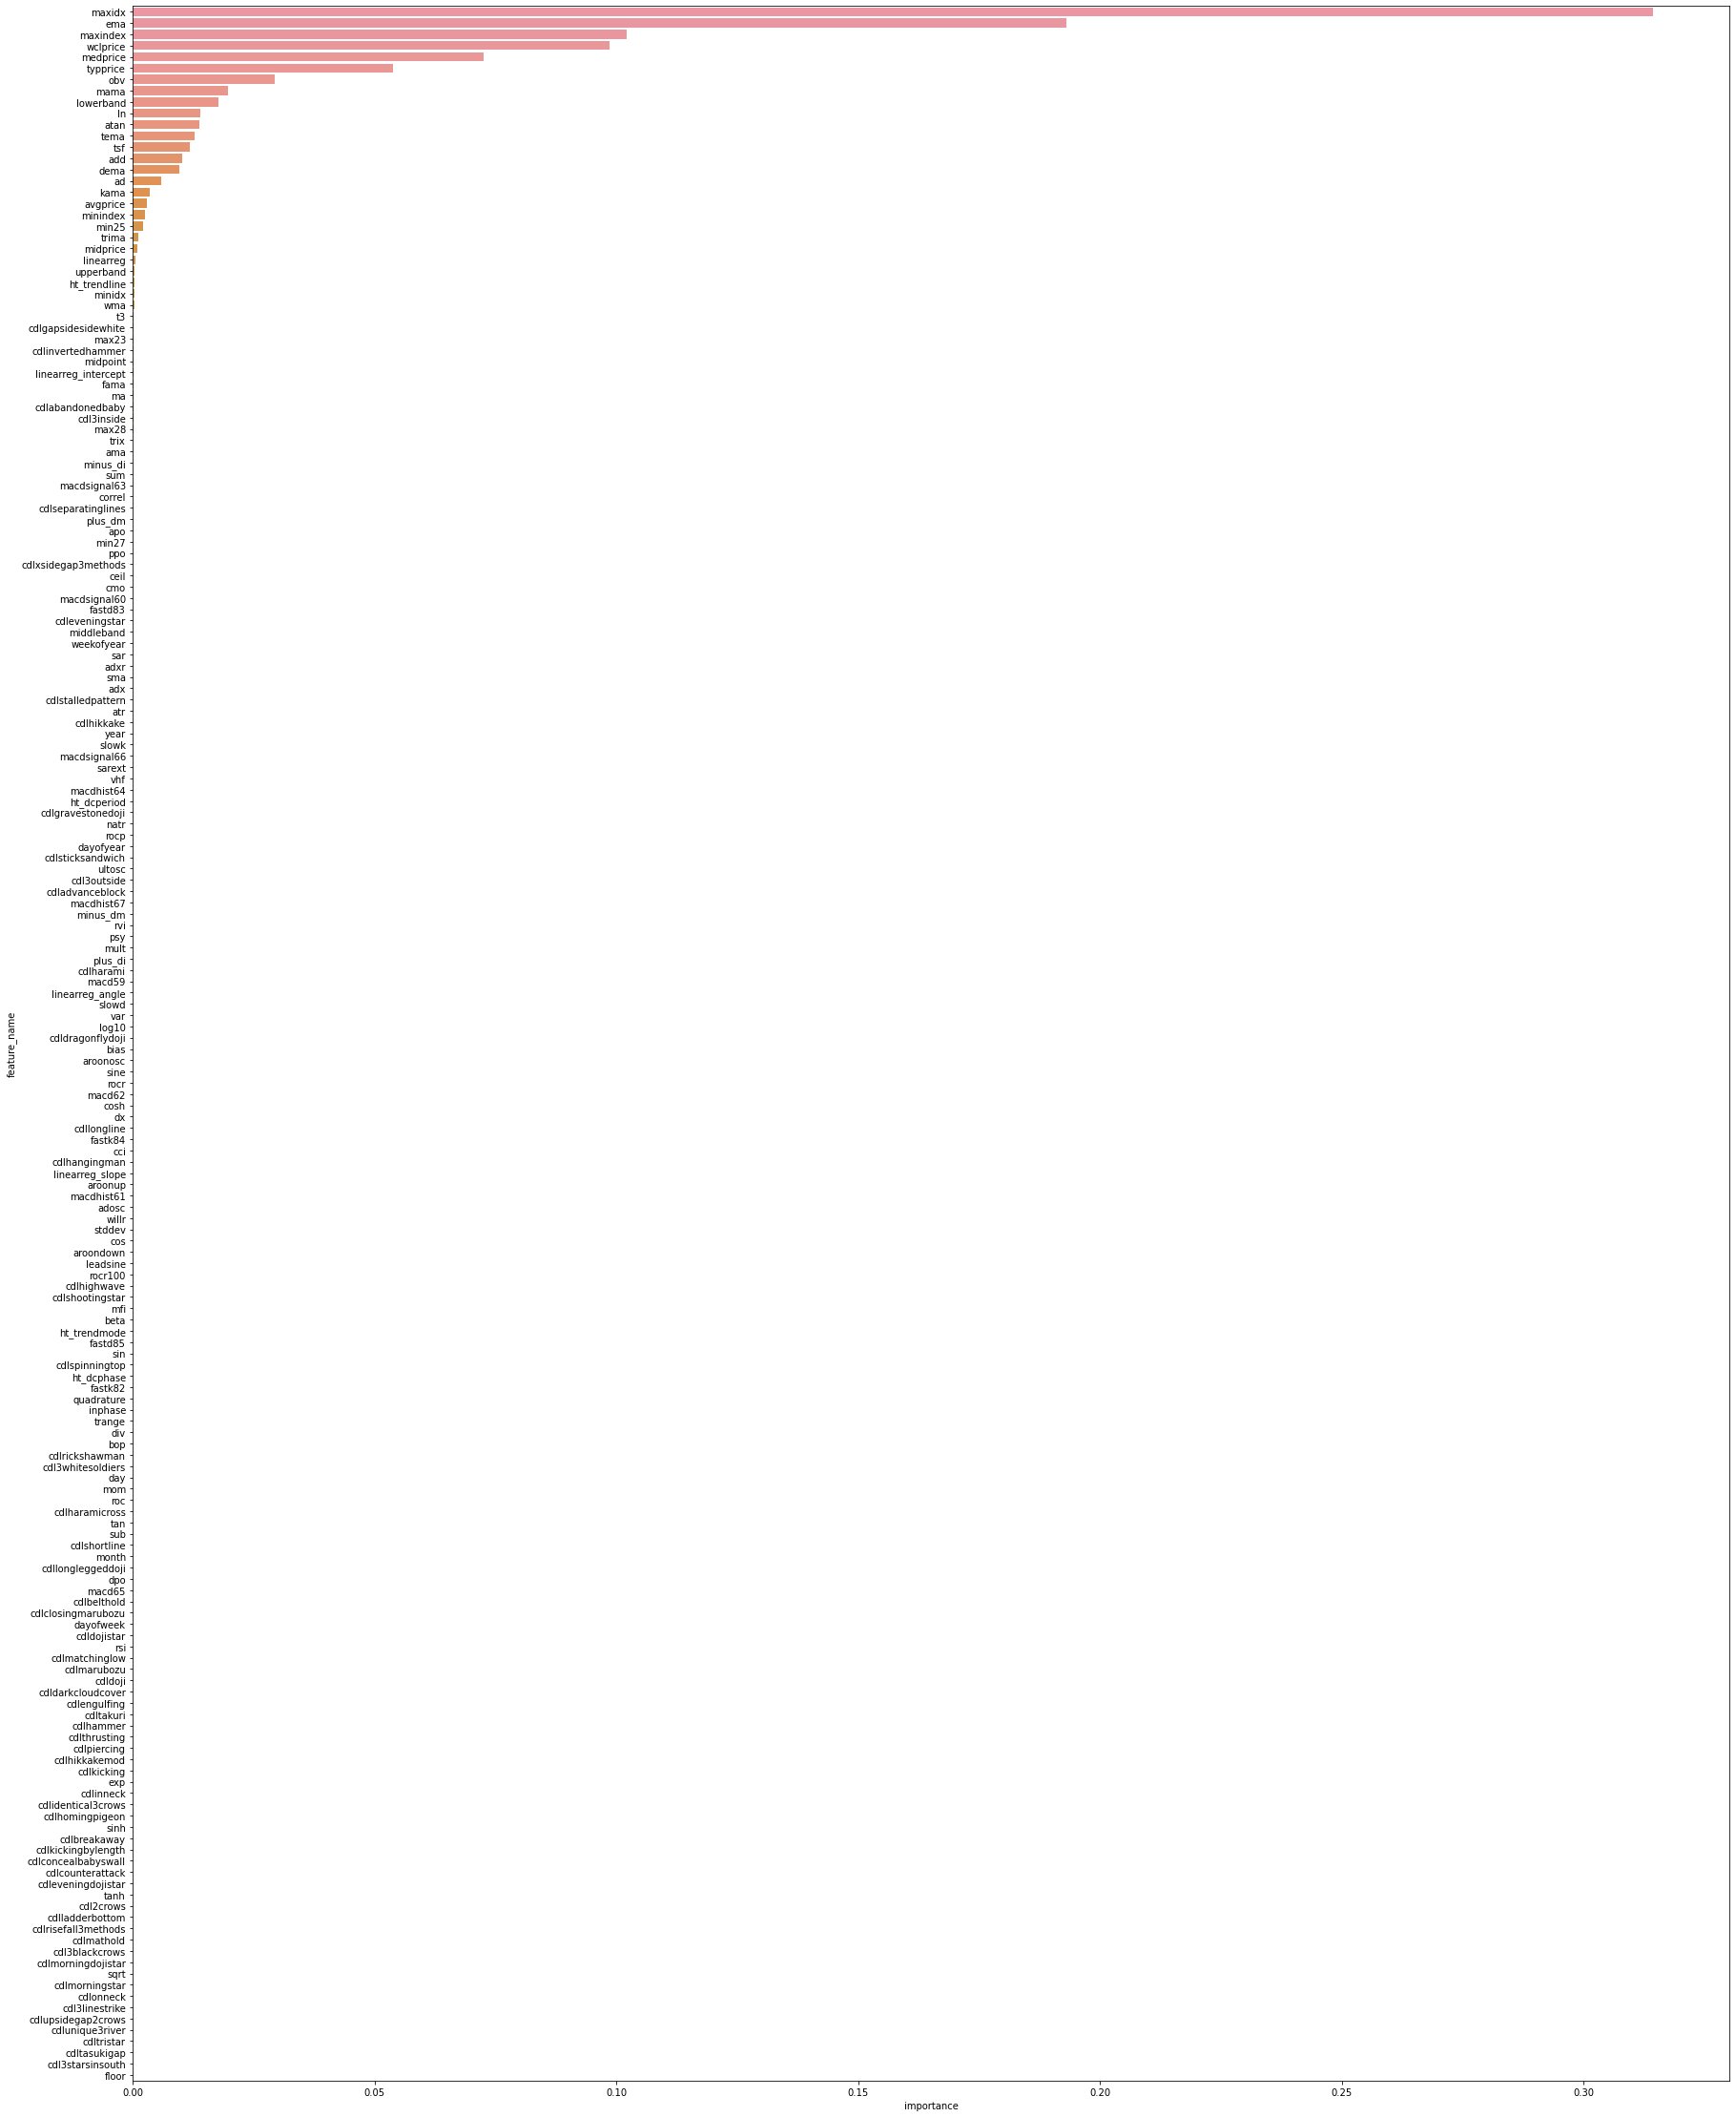

In [ ]:
for i in range(20,len(stocks_name)):

  stock = df[df['name']==stocks_name[0]].loc[:,:'rvi']
  X = stock.loc[:,'year':'rvi'].values
  y = stock.iloc[:, -1].values

  X_column_name = list(stock.loc[:,'year':'rvi'].columns)
  X_train, X_test, y_train, y_test = data_shift_split(stock)
  df_result_default = XGB_params_default(X_train, X_test, y_train, y_test )
  best = XGB_params_select(X,y)
  df_mseR2 = XGB_params_best(X_train, X_test, y_train, y_test)
  importance = features_ranking_table(X_column_name,best)
  features_ranking_bar(importance)
  
  # 列印表格
  mse_comparison = pd.concat([importance, df_result_default, df_mseR2], ignore_index = True)
  mse_comparison.to_csv(f'/content/drive/MyDrive/Final Project/XGboost/feature/{stocks_name[i]}_features_mse_r2.csv', index = False)
  print(i)
  